## A2.1 Regresión logística y validación cruzada

***

**1.** Se importa la libreria pandas para cargar el archivo *student dropout* con la base de datos a usar. Se selecciona la variable de salida *Dropped_Out*, que en este caso se hace una conversión de los valores *yes* y *no* a binarios para que puedan ser utilizados a lo largo del trabajo.

In [4]:
import pandas as pd
df=pd.read_csv("student dropout.csv")

df["Dropped_Out"]=df["Dropped_Out"].astype(int)
print(df.head(5))

  School Gender  Age Address Family_Size Parental_Status  Mother_Education  \
0     GP      F   18       U         GT3               A                 4   
1     GP      F   17       U         GT3               T                 1   
2     GP      F   15       U         LE3               T                 1   
3     GP      F   15       U         GT3               T                 4   
4     GP      F   16       U         GT3               T                 3   

   Father_Education Mother_Job Father_Job  ... Free_Time Going_Out  \
0                 4    at_home    teacher  ...         3         4   
1                 1    at_home      other  ...         3         3   
2                 1    at_home      other  ...         3         2   
3                 2     health   services  ...         2         2   
4                 3      other      other  ...         3         2   

   Weekend_Alcohol_Consumption  Weekday_Alcohol_Consumption  Health_Status  \
0                            1  

***

**2.** Se importan *train_test_split* y *cross_val_score* de la liberia sklearn. 

Antes de entrenar el modelo se imprime la proporción de clase en los datos originales. 
Luego se separa la base de datos en entrenamiento y prueba con una proporción 80/20. Para mantener el balance de clases se utiliza *stratify=y*. Este parámetro se asegura de que tanto el conjunto de entrenamiento como el de prueba conserven aprox. la misma proporción de clases que los datos originales, ayudando a evitar problemas de sesgo. Posterior, se muestran las proporciones de clases en ambas partes, tanto en entrenamiento como prueba.

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score

proporcion_og= df["Dropped_Out"].value_counts(normalize=True)
print("Proporción de clases en datos originales:",proporcion_og)

X=df.drop(columns=["Dropped_Out"])
y=df["Dropped_Out"]
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\nProporción de clases en datos de entrenamiento:",y_train.value_counts(normalize=True))
print("\nProporción de clases en datos de prueba:",y_test.value_counts(normalize=True))

Proporción de clases en datos originales: Dropped_Out
0    0.845917
1    0.154083
Name: proportion, dtype: float64

Proporción de clases en datos de entrenamiento: Dropped_Out
0    0.845857
1    0.154143
Name: proportion, dtype: float64

Proporción de clases en datos de prueba: Dropped_Out
0    0.846154
1    0.153846
Name: proportion, dtype: float64


***

**3.** Se importa *LogisticRegression, confusion_matrix, accuracy_score, recall_score, roc_curve, roc_auc_score*, todas estas de la libreria sklearn  para realizar todos los cálculos necesarios. 

Primeramente se convierten las variables categóricas en variables númericas con one-hot encoding. Se entrena un modelo de regresión logística utilizando únicamente los datos de entrenamiento y se evalúa su desempeño con una técnica de validación cruzada.

Al momento de crear el modelo de regresión logística se utiliza el parámetro "class_weight=balanced", lo que ajusta los pesos de las clases para compensar el desbalance. Así mismo, el parámetro *max_iter* establece el número máximo de iteraciones para asegurar convergencia.

Se usa validación cruzada con 10 folds para evaluar el modelo, midiendo la exactitud en cada uno de estos. Después se calcula el promedio de exactitud en los 10 folds, permitiendo evaluar la capacidad predictiva del modelo sin sobre ajustarlo a un solo conjunto de datos.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, roc_auc_score

one_hot_train=pd.get_dummies(X_train, drop_first=True)
reg_log=LogisticRegression(max_iter=250, random_state=42, class_weight="balanced")
cv=cross_val_score(reg_log, one_hot_train, y_train, cv=10, scoring="accuracy")
print("Exactitud promedio en validación cruzada:", cv.mean())

Exactitud promedio en validación cruzada: 0.9980392156862745


***

**4.** Utilizando ahora todo el conjunto de datos se vuelve a entrenar un modelo con regresión logística y se generan predicciones en términos de probabilidades para los datos de prueba.

Se aplican las mismas transformaciones de one-hot encoding al conjunto de prueba. Se ajusta el modelo usando todos los datos y genera la probabilidad de pertenecer a la clase 1 (abandonar los estudios). Debido a que la curva ROC normalmente evalúa la capacidad del modelo para predecir la clase positiva (abandono), se usa la columna 1 la cual contiene la probabilidad de que la observación pertenezca a esa clase.

Se evalua con 3 umbrales diferentes, en este caso en particular se seleccionaron el 0.3, 0.5, 0.7. Para cada umbral, se hacen predicciones y se evalúan métricas. Se construye la matriz de confusión que indica cuántos casos fueron correctamente e incorrectamente clasificados. 

Así mismo en cada evaluación se obtiene la sensibilidad (cuántos de los que realmente abandonaron fueron detectados correctamente), exactitud (porcentaje de predicciones correctas) y especificidad (cuántos de los que no abandonaron fueron clasificados correctamente), así como una matríz de confusión.

Umbral 0.3 indica menos falsos positivos pero más falsos negativos.

Umbral 0.5 indica una clasificación balanceada.

Umbral 0.7 indica más falsos positivos pero menos falsos negativos.

***

In [14]:
one_hot_test=pd.get_dummies(X_test,drop_first=True)
reg_log.fit(one_hot_train,y_train)
y_prob=reg_log.predict_proba(one_hot_test)[:,1]

y_pred_3=(y_prob>=0.3).astype(int)
mc_3=confusion_matrix(y_test, y_pred_3)
accuracy_3=accuracy_score(y_test, y_pred_3)
sensitivity_3=recall_score(y_test, y_pred_3)
specificity_3=mc_3[0, 0]/(mc_3[0, 0]+mc_3[0, 1])
print("Resultados para umbral 0.3")
print("Exactitud:", round(accuracy_3, 4), ", Sensibilidad:", round(sensitivity_3, 4),", Especificidad:", round(specificity_3, 4))
print("Matriz de confusión")
print(mc_3)

y_pred_5=(y_prob>=0.5).astype(int)
mc_5=confusion_matrix(y_test, y_pred_5)
accuracy_5=accuracy_score(y_test, y_pred_5)
sensitivity_5=recall_score(y_test, y_pred_5)
specificity_5=mc_5[0, 0]/(mc_5[0, 0]+mc_5[0, 1])
print("\nResultados para umbral 0.5")
print("Exactitud:", round(accuracy_5, 4), ", Sensibilidad:", round(sensitivity_5, 4),", Especificidad:", round(specificity_5, 4))
print("Matriz de confusión")
print(mc_5)

y_pred_7=(y_prob>=0.7).astype(int)
mc_7=confusion_matrix(y_test, y_pred_7)
accuracy_7=accuracy_score(y_test, y_pred_7)
sensitivity_7=recall_score(y_test, y_pred_7)
specificity_7=mc_7[0, 0]/(mc_7[0, 0] + mc_7[0, 1])
print("\nResultados para umbral 0.7")
print("Exactitud:", round(accuracy_7, 4), ", Sensibilidad:", round(sensitivity_7, 4),", Especificidad:", round(specificity_7, 4))
print("Matriz de confusión")
print(mc_7)

Resultados para umbral 0.3
Exactitud: 0.9615 , Sensibilidad: 0.95 , Especificidad: 0.9636
Matriz de confusión
[[106   4]
 [  1  19]]

Resultados para umbral 0.5
Exactitud: 0.9846 , Sensibilidad: 0.95 , Especificidad: 0.9909
Matriz de confusión
[[109   1]
 [  1  19]]

Resultados para umbral 0.7
Exactitud: 0.9846 , Sensibilidad: 0.95 , Especificidad: 0.9909
Matriz de confusión
[[109   1]
 [  1  19]]


***

**5.** Una vez realizados los cálculos y entrenamientos de los modelos, se importa *matplotlib.pyplot* para revisar de una manera más visual los resultados obtenidos. Se grafica la cruva ROC y obtiene su valor AUC del modelo.

La curva ROC muestra el rendimiento del modelo a distintos umbrales de clasificación.
En el eje x (Tasa de Falsos Positivos) se muestran cuántos de los estudiantes que no abandonaron fueron clasificados erróneamente como si abandonaran.
En el eje y (Tasa de Verdaderos Positivos) se muestran cuántos de los estudiantes que sí abandonaron fueron clasificados correctamente como tales.

El valor AUC= 0.9945 indica el área bajo la curva lo cual mide la capacidad del modelo para diferenciar entre los estudiantes que abandonan y los que no. La curva alta y hacia la esquina superior izquierda de la gráfica indica un buen modelo, es decir, tiene alta sensibilidad y baja tasa de falsos positivos, lo que significa que clasifica correctamente la mayoría de los casos.

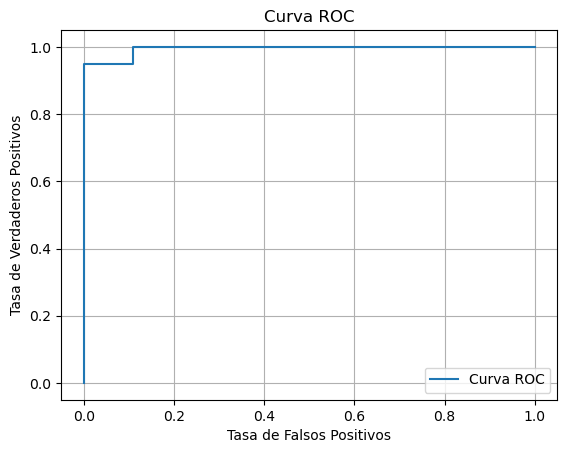

AUC del modelo: 0.9945


In [17]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds=roc_curve(y_test, y_prob)
auc=roc_auc_score(y_test, y_prob)

plt.plot(fpr, tpr, label='Curva ROC')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()
plt.grid()
plt.show()

print("AUC del modelo:", round(auc,4))

***

**6.** Por último utilizando los coeficientes obtenidos es posible determinar el efecto de cada una de las variables en la de salida, siendo en este caso *Dropped_Out*. 

In [20]:
coeficientes=pd.DataFrame({"Variable": one_hot_train.columns, "Coeficiente": reg_log.coef_[0]})
print("Coeficientes del modelo:")
print(coeficientes)

Coeficientes del modelo:
                                 Variable  Coeficiente
0                                     Age    -0.411684
1                        Mother_Education    -0.133040
2                        Father_Education    -0.025497
3                             Travel_Time     0.043929
4                              Study_Time    -0.167011
5                      Number_of_Failures     0.035866
6                     Family_Relationship     0.013621
7                               Free_Time    -0.000572
8                               Going_Out     0.119692
9             Weekend_Alcohol_Consumption     0.124677
10            Weekday_Alcohol_Consumption     0.113139
11                          Health_Status    -0.085838
12                     Number_of_Absences    -0.051861
13                                Grade_1    -0.726576
14                                Grade_2    -0.587232
15                            Final_Grade    -4.179842
16                              School_M

Los coeficientes positivos aumentan la probabilidad de abandono, los negativos reducen la probabilidad de abandono, y los coeficientes cercanos a cero tienen poco impacto en la decisión de abandonar.

El modelo de regresión logística estima la probabilidad de que un estudiante abandone o no sus estudios y cada coeficiente representa el cambio en la probabilidad de abandono por cada unidad de aumento en la variable, manteniendo las demás constantes.

Tomando como ejemplo 3 variables, para este caso en específico:
- School_Support_yes (-0.0240): indica que tener apoyo escolar reduce ligeramente la probabilidad de abandono.
- Family_Support_yes (-0.1285): indica que contar con apoyo familiar disminuye la probabilidad de abandono.
- Internet_Access_yes (+0.1255): inidica que tener accesso a internet aumenta ligeramente la probabilidad de abandono.